#### Compute the Camera Calibration Matrix and Distortion Coefficients

The first cell in the Jupyter notebook contain the camera calibration code. I started by looking for the 9 x 6 chessboard corners in each of the images. 3 of the images did not contain all 9 x 6 corners so those 3 images were skipped. For the other images, the points of the detected corners were saved and used to compute the camera calibration and distortion coefficients. 

The matrix and distortion coeffients are saved and used in the `cv2.undistort()` function on the test image.

#### Import Modules

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
print('modules imported')

modules imported


### Camera Calibration

In [2]:
def calibrate_camera(nx, ny):
    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    images = glob.glob('camera_cal/calibration*.jpg')

    for fname in images:
        img = cv2.imread(fname)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # If found, draw corners
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        else:
            print("could not find all corners in," + fname)
    ret, mtx, dist, rvecs, tves = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2],None,None)
    return mtx, dist

### Distortion Correction

In [3]:
def undistort(image, mtx, dist):
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst

#### Test the calibration

could not find all corners in,camera_cal/calibration1.jpg
could not find all corners in,camera_cal/calibration4.jpg
could not find all corners in,camera_cal/calibration5.jpg
Resolution:  (720, 1280)


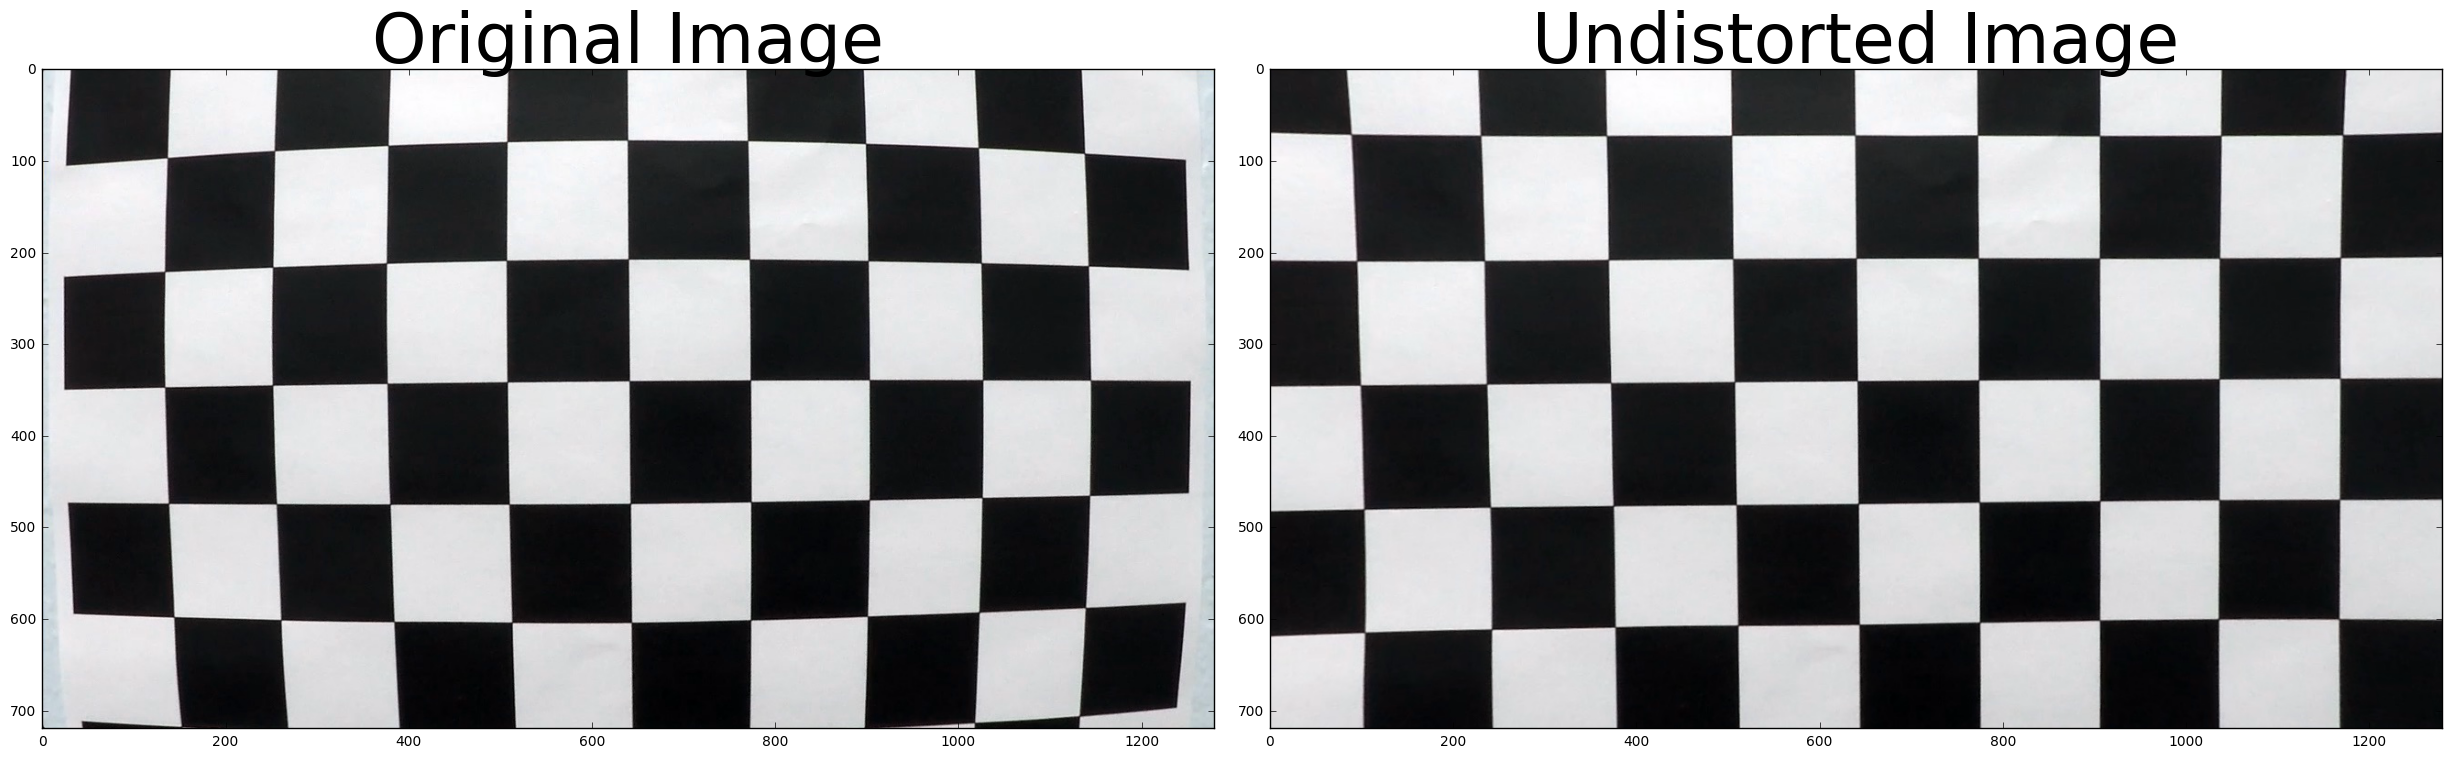

In [4]:
nx = 9 # number of corners in x
ny = 6 # number of corners in y
test_image = cv2.imread('camera_cal/calibration1.jpg')
mtx, dist = calibrate_camera(nx, ny)
undist = undistort(test_image, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
print("Resolution: ", test_image.shape[0:2])

### Single image preprocessing
#### Color and gradient thresholding
In the code below I defined a `find_yellow_lines()` and `find_white_lines()` function. The goal was to first use color and gradient thresholding on yellow and white lines seperatly. Then to combine the binary results in the `find_lines()` function. I used `mag_thresh()` to create a larger surface area of detected pixels.

In [5]:
def find_yellow_lines(img, sobel_kernel=3, c_thresh=(0,111)):
    """Converts to YCrBr. Combines Color and Gradient thresholding"""
    image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    gray = image[:,:,2]
    gray_blur = gaussian_blur(gray, 9)
    
    # gradient thresholding
    sobelx = cv2.Sobel(gray_blur, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= 35) & (scaled_sobelx <= 121)] = 1
    
    # color thresholding
    cbinary = np.zeros_like(gray)
    cbinary[(gray >= c_thresh[0]) & (gray <= c_thresh[1])] = 1
    
    combined = np.bitwise_or(sxbinary, cbinary)
    return combined

def find_white_lines(img, sobel_kernel=3, c_thresh=(45,111)):
    image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    gray = image[:,:,0]
    gray_blur = gaussian_blur(gray, 5)
    
    # gradient thresholding
    sobelx = cv2.Sobel(gray_blur, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= 35) & (scaled_sobelx <= 121)] = 1
    
    # color thresholding
    cbinary = np.zeros_like(gray)
    cbinary[(gray >= c_thresh[0]) & (gray <= c_thresh[1])] = 1
    
    combined = np.bitwise_or(sxbinary, cbinary)
    return combined

def find_lines(img):
    white = find_white_lines(img, c_thresh=(200,255))
    yellow = find_yellow_lines(img, c_thresh=(0,110))
    combined = np.bitwise_or(white, yellow)
    # get magnitude gradient of v channel
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = gray[:,:,2]
    mag = mag_thresh(gray, ksize=15, mag_thresh=(50, 255))
    
    combined = np.bitwise_or(combined, mag)
    return combined

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def mag_thresh(image, ksize=3, mag_thresh=(0, 255)):
    """Applies magnitude gradient calculation of single channel image: gray, H, S, etc..."""
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=ksize)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

In [6]:
images = glob.glob('test_images/*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    binary = find_lines(img)
    dst = np.zeros_like(binary)
    cv2.convertScaleAbs(binary, dst, 255.0);
    cv2.imwrite('output_images/' + 'binary_' + os.path.basename(fname), dst)
print("done")

done


#### Perspective transform
The code below uses `get_perspective_transform_matrix()` to get the perspective transform matrix that will be used on the rest of the images in the pipeline. I chose hardcoded source and destination points similar to ones given in the example writeup. I used the camera calibration matrix from the initial camera calibration step.

The function `warp()` takes the perspective transform matrix to perform the perspective transform. I verified that my perspect transform works by looking at a test image and verifiying that the transformed lane line appear pretty close to parallel. For both straight and curved lane lines.

In [7]:
def get_perspective_transform_matrix(img, mtx, dist):
    # Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # image size
    ySize = gray.shape[0]
    xSize = gray.shape[1]
    img_size = (xSize, ySize)
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    src = np.float32(
        [[(img_size[0] / 2) - 65, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 50, img_size[1]],
        [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 3.9), 0]])
    M = cv2.getPerspectiveTransform(src, dst)  
    return M, img_size

def draw_roi(image, top_down):
    image = np.copy(image)
    ySize = gray.shape[0]
    xSize = gray.shape[1]
    img_size = (xSize, ySize)
    src = np.int32(
        [[(img_size[0] / 2) - 65, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 50, img_size[1]],
        [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
    dst = np.int32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    image = cv2.polylines(image,[src],True,(0,255,255), thickness=2)
    pipeline_image = cv2.polylines(top_down,[dst],True,(0,255,255), thickness=2)
    return image, pipeline_image

def warp(img, M):
    # M is the perspective transform matrix
    # use cv2.warpPerspective() to warp image to a top-down view
    # img_size in the form of (width , height)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

def unwarp(img, M):
    # M is the perspective transform matrix
    # use cv2.warpPerspective() to unwarp image back to a standard view
    # img_size in the form of (width , height)
    img_size = (img.shape[1], img.shape[0])
    mInv = np.linalg.inv(M)
    warped = cv2.warpPerspective(img, mInv, img_size)
    return warped

def find_base_of_lane_lines(img):
    """Takes binary warped image as param. Returns base location of lane lines detected"""
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    
    # output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))*255
    
    #plt.imshow(out_img)
    peak1 = int(np.argmax(histogram)) # index location of the first peak
    
    # split histogram and search for next peak
    a, b = np.split(histogram, 2)
    peak2 = int(np.argmax(b) + len(histogram)/2) # index location of the second peak
    return peak1, peak2, out_img

def test_hist(img):
    hist = np.sum(img[img.shape[0]/2:,:], axis=0)
    return hist

True

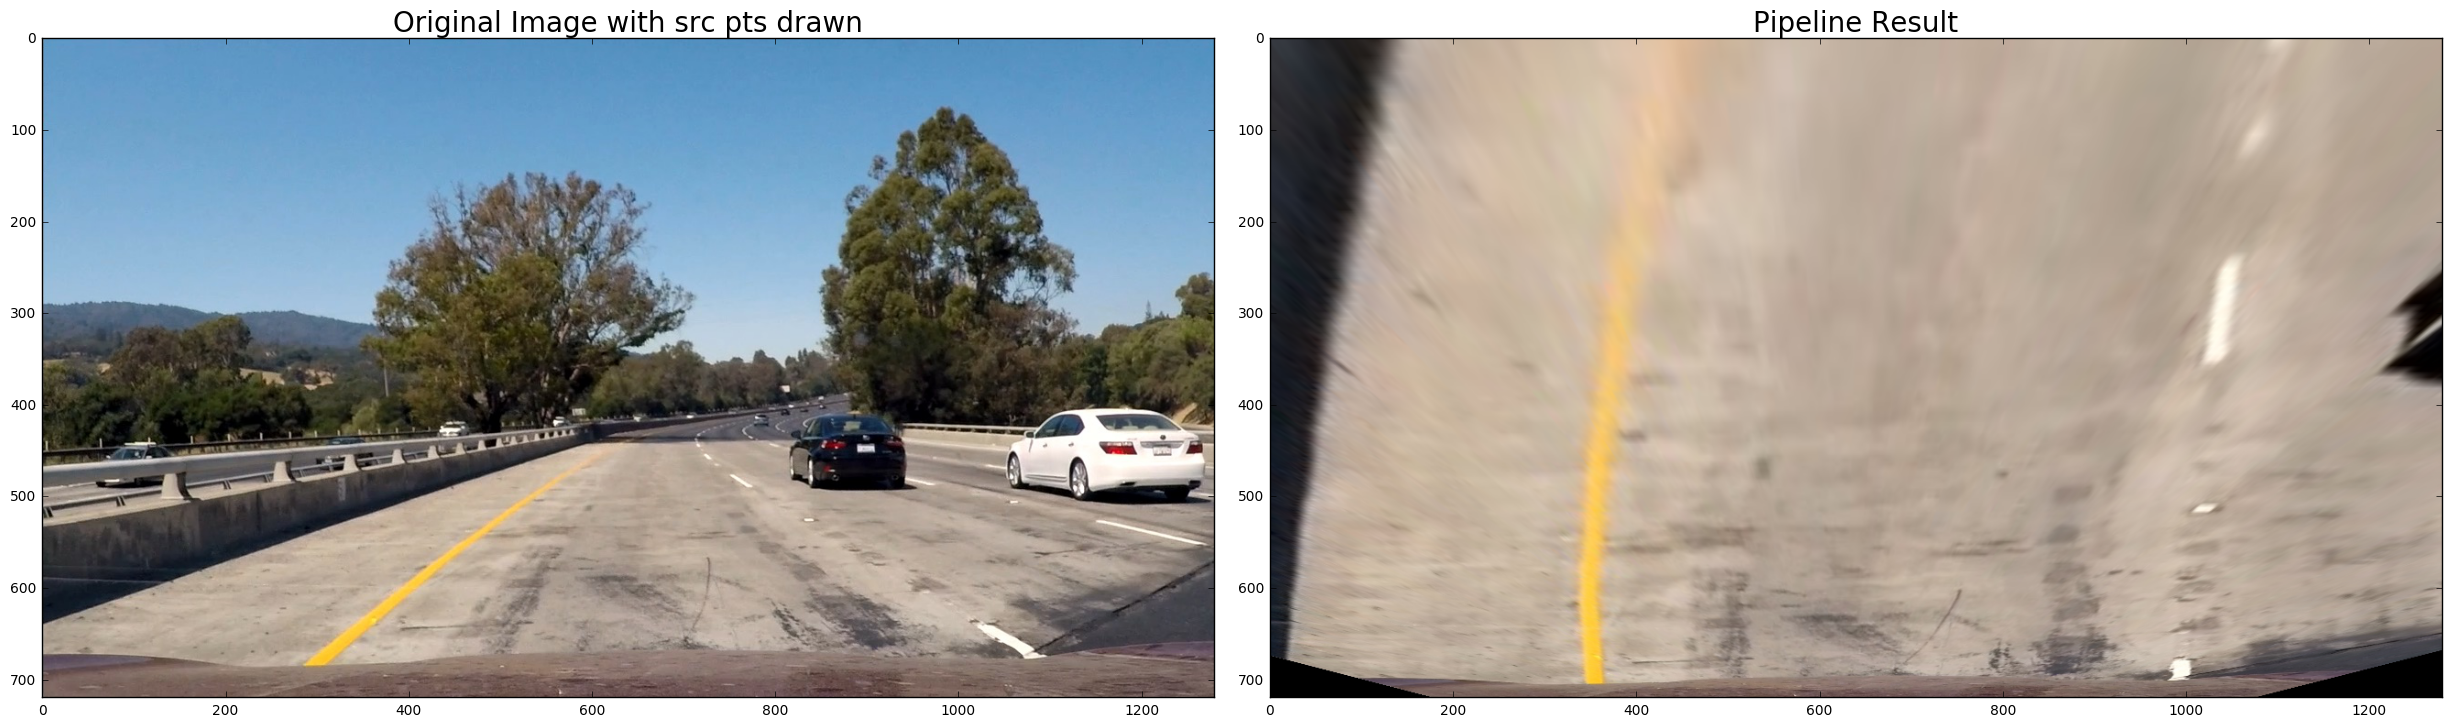

In [8]:
image = mpimg.imread('./test_images/test1.jpg')
top_down = find_lines(image)
# get the perspective transform matrix
M, img_size = get_perspective_transform_matrix(image, mtx, dist)
# Warp the image and draw the src and dest rects
top_down = warp(image, M)
#roi, top_down = draw_roi(image, top_down)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image with src pts drawn', fontsize=20)

ax2.imshow(top_down, cmap="gray")
ax2.set_title('Pipeline Result', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
cv2.imwrite('output_images/perspective_transform.jpg', top_down)

/Users/ginobernardi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:76: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ginobernardi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


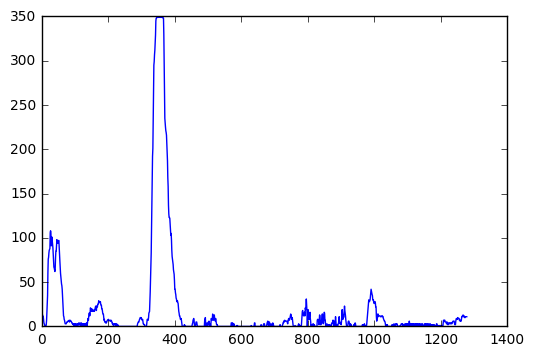

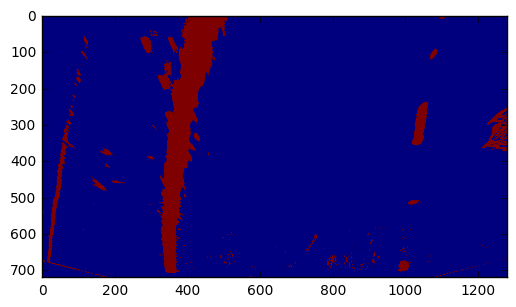

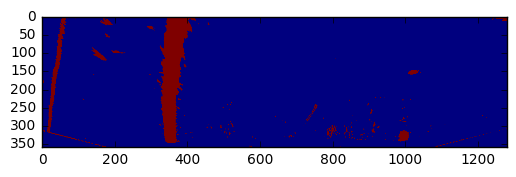

In [9]:

image = mpimg.imread('./test_images/test1.jpg')
image = warp(image, M)
image = find_lines(image)
h = test_hist(image)
plt.plot(h)
plt.figure()
plt.imshow(image)
im = image[image.shape[0]/2:,:]
plt.figure()
plt.imshow(im)

### Find lane line pixels and fit 2nd order polynomial to their positions
I used the starter code given in the lecture to find the lane lines and fit polynomials to them. I hope to find more time to review this step later and improve the code

In [10]:
def find_lane_lines(image, window_size):
    """Takes the binary top down image and window_size"""
    peak1, peak2, out_img = find_base_of_lane_lines(image)
    
    # choose the number of sliding windows
    nwindows = 10
    window_height = np.int(image.shape[0]/nwindows)
    
    # identify the x and y position of all non zero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # current positions to be updated for each window
    leftx_current = peak1
    rightx_current = peak2
    # set the width of the windows margin
    margin = 80
    
    # set minimum number of pixels found to recenter window
    minpix = 50
    
    # create empty lists to receive left and right lane pixel indices
    left_lane_idxs = []
    right_lane_idxs = []
    
    # step through the windows one by one
    for window in range(nwindows):
        # identify window boundaries in x and y (and right and left)
        win_y_low = int(image.shape[0] - (window+1)*window_size)
        win_y_high = int(image.shape[0] - window*window_size)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                      (win_xleft_high, win_y_high), (0,255,0),2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
                      (win_xright_high,win_y_high),(0,255,0), 2)
        # identify the non zero pixels in x and y within the window
        good_left_idxs = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                         (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_idxs = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_idxs.append(good_left_idxs)
        right_lane_idxs.append(good_right_idxs)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_idxs) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_idxs]))
        if len(good_right_idxs) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_idxs]))
        
    # Concatenate the arrays of indices
    left_lane_idxs = np.concatenate(left_lane_idxs)
    right_lane_idxs = np.concatenate(right_lane_idxs)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_idxs]
    lefty = nonzeroy[left_lane_idxs] 
    rightx = nonzerox[right_lane_idxs]
    righty = nonzeroy[right_lane_idxs] 

    # Fit a second order polynomial to each
    left_fit = []
    right_fit = []
    
    # make sure we found lines
    if not np.any(righty) or not np.any(rightx) or not np.any(lefty) or not np.any(leftx):
        pass
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        out_img[nonzeroy[left_lane_idxs], nonzerox[left_lane_idxs]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_idxs], nonzerox[right_lane_idxs]] = [0, 0, 255]
#         plt.imshow(out_img)
#         plt.plot(left_fitx, ploty, color='yellow')
#         plt.plot(right_fitx, ploty, color='yellow')
#         plt.xlim(0, 1280)
#         plt.ylim(720, 0)
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty, out_img

# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def find_lane_lines_from_previous(img, left_fit, right_fit):
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if not np.any(righty) or not np.any(rightx) or not np.any(lefty) or not np.any(leftx):
        pass
    else:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        fity = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
        right_fitx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((img, img, img))*255
        window_img = np.zeros_like(out_img)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [0, 255, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 255, 0]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, fity]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, fity])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, fity]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, fity])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
#         cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#         cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#         result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#         plt.imshow(result)
#         plt.plot(left_fitx, fity, color='yellow')
#         plt.plot(right_fitx, fity, color='yellow')
#         plt.xlim(0, 1280)
#         plt.ylim(720, 0)

        # Define y-value where we want radius of curvature
        # example chose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(fity)
        left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the new radius of curvature in meters
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    return left_fit, right_fit, left_fitx, right_fitx, fity, left_curverad, right_curverad, out_img

In [11]:
# def plot_lane_fit(image, left_fit, right_fit):# Generate x and y values for plotting
#     out_img = np.dstack((image, image, image))*255
#     ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     #out_img[nonzeroy[left_lane_idxs], nonzerox[left_lane_idxs]] = [255, 0, 0]
#     #out_img[nonzeroy[right_lane_idxs], nonzerox[right_lane_idxs]] = [0, 0, 255]
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)


/Users/ginobernardi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


True

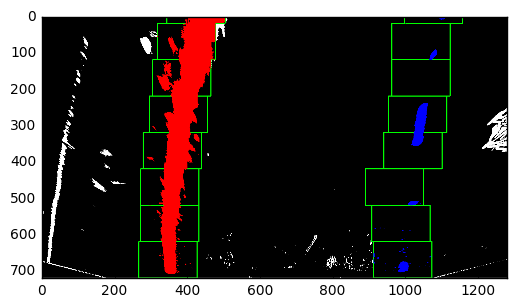

In [12]:
image = mpimg.imread('./test_images/test1.jpg')
top_down_binary = find_lines(top_down)
left_fit, right_fit, left_fitx, right_fitx, fity, out_img = find_lane_lines(top_down_binary, 100.)
#plot_lane_fit(out_img, left_fit, right_fit)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.imshow(out_img)
#find_lane_lines_from_previous(top_down_binary, left_fit, right_fit)
cv2.imwrite('output_images/discovered_lane_lines.jpg', out_img)


## Test pipeline on Video

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
class Line():
    def __init__(self, M, mtx, dist):
        # constants
        self.M = M # perspective transform matrix
        self.mtx = mtx # camera calibration matrix
        self.dist = dist # camera calibration points
        self.img_size = None
        
        # _blind_search and _targeted_search will modify these
        self.left_fit = []
        self.right_fit = []
        self.left_fitx = []
        self.right_fitx = []
        self.fity = None
        self.curve = None
        self.vehicle_offset = None
        self.detected = False 
        self.currentBinaryWarpedFrame = []
        self.nframes = 0 # number of iterations (frames)
    
    def __blind_search(self, image):
        # make a copy of the image
        img = np.copy(image)
        # undistort image with mtx
        undist = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)

        # appply perspective transform with M
        warped = cv2.warpPerspective(undist, self.M, self.img_size)

        # apply color and gradient thresholding, returns binary image
        warped_binary = find_lines(warped)
        
        #fit lines
        left_fit, right_fit, left_fitx, right_fitx, fity, img_out = find_lane_lines(warped_binary, 100.)
        
        if not np.any(left_fit) or not np.any(right_fit):
            #unwarped = unwarp(warped, self.M)
            self.detected = False
        else:
            self.left_fit = left_fit
            self.right_fit = right_fit
            self.left_fitx = left_fitx
            self.right_fitx = right_fitx
            self.fity = fity
            #unwarped = unwarp(img_out, self.M)  
            self.detected = True
        
        weighted = self.__weighted_img(img_out, image)
        return weighted
    
    def __targeted_search(self, image):
        # make a copy of the image
        img = np.copy(image)
        # undistort image with mtx
        undist = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)

        # appply perspective transform with M
        warped = cv2.warpPerspective(undist, self.M, self.img_size)

        # apply color and gradient thresholding, returns binary image
        warped_binary = find_lines(warped)

        #fit lines
        left_fit, right_fit, left_fitx, right_fitx, fity, left_curverad, right_curverad, img_out = find_lane_lines_from_previous(warped_binary, self.left_fit, self.right_fit)
        
        if not np.any(left_fit) or not np.any(right_fit):
            #unwarped = unwarp(warped, self.M)
            self.detected = False
        else:
            self.left_fit = left_fit
            self.right_fit = right_fit
            self.left_fitx = left_fitx
            self.right_fitx = right_fitx
            self.fity = fity
            self.left_curve = left_curverad
            self.right_curve = right_curverad
            #unwarped = unwarp(img_out, self.M)  
            self.detected = True
        
        weighted = self.__weighted_img(img_out, image)
        self.curve = 0.5*(left_curverad + right_curverad)
        
        return weighted
    
    def __weighted_img(self, img, initial_img, α=.8, β=1., λ=1.):
        """
        `img` is the warped image.
        Should be a blank image (all black) with lanes drawn on it.
        `initial_img` should be the image before any processing.
        The result image is computed as follows:
        initial_img * α + img * β + λ
        NOTE: initial_img and img must be the same shape!
        """
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(img).astype(np.uint8)

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([self.left_fitx, self.fity]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx, self.fity])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))
        
        mInv = np.linalg.inv(M)
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(warp_zero, mInv, (image.shape[1], image.shape[0])) 
        
        # Combine the result with the original image
        result = cv2.addWeighted(initial_img, 1, newwarp, 0.3, 0)
        
        return result    
    
    def __calc_vehicle_offset(self,img):
        xm_per_pix = 3.7/700
        # left_center is x position in pixels from left edge of image
        # assume camera is in center of image
        center = self.img_size[0]/2
        left_center = self.left_fitx[0]
        self.vehicle_offset = (3.7/2) - xm_per_pix * (center - left_center)
        offset = str(self.vehicle_offset) + ' meters from center'
        cv2.putText(img, offset, (125,50), cv2.FONT_HERSHEY_DUPLEX, 0.7, (255,255,255))
    
    def pipeline(self, img):
        if not self.img_size:
            self.img_size = (img.shape[1], img.shape[0])
            self.nframes+=1
        
        if self.detected == True:
            binary_warped = self.__targeted_search(img)
        else:
            binary_warped = self.__blind_search(img)
        
        weighted = self.__weighted_img(binary_warped, img)
        self.__calc_vehicle_offset(weighted)
        curve = str(self.curve)
        cv2.putText(weighted, curve, (125,25), cv2.FONT_HERSHEY_DUPLEX, 0.7, (255,255,255))
        return weighted


True

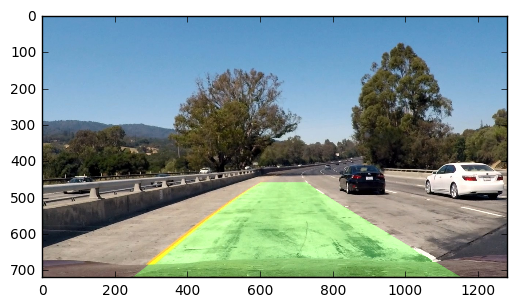

In [17]:
image = mpimg.imread('./test_images/test1.jpg')
top_down_binary = find_lines(top_down)
left_fit, right_fit, left_fitx, right_fitx, fity, warped = find_lane_lines(top_down_binary, 100.)

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
#color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, fity]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, fity])))])

pts = np.hstack((pts_left, pts_right))
# Draw the lane onto the warped blank image
cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))

mInv = np.linalg.inv(M)
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(warp_zero, mInv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
cv2.imwrite('output_images/detected_lane.jpg', result)

In [19]:
project_output = 'project_video_out.mp4'
#clip1 = VideoFileClip('./project_video.mp4').subclip(0,2)
clip1 = VideoFileClip('./project_video.mp4')

line = Line(M, mtx, dist)
project_clip = clip1.fl_image(line.pipeline)
%time project_clip.write_videofile(project_output, audio=False)  


[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [06:13<00:00,  2.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 6min 35s, sys: 1min 53s, total: 8min 28s
Wall time: 6min 15s


In [23]:
project_output = 'challenge_video_out.mp4'
#clip1 = VideoFileClip('./project_video.mp4').subclip(0,2)
clip1 = VideoFileClip('./challenge_video.mp4')

line = Line(M, mtx, dist)
project_clip = clip1.fl_image(line.pipeline)
%time project_clip.write_videofile(project_output, audio=False) 

[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4


100%|██████████| 485/485 [02:16<00:00,  3.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out.mp4 

CPU times: user 2min 23s, sys: 42.2 s, total: 3min 6s
Wall time: 2min 17s


In [21]:
project_output = 'harder_challenge_video_out.mp4'
#clip1 = VideoFileClip('./project_video.mp4').subclip(0,2)
clip1 = VideoFileClip('./harder_challenge_video.mp4')

line = Line(M, mtx, dist)
project_clip = clip1.fl_image(line.pipeline)
%time project_clip.write_videofile(project_output, audio=False) 

[MoviePy] >>>> Building video harder_challenge_video_out.mp4
[MoviePy] Writing video harder_challenge_video_out.mp4


100%|█████████▉| 1199/1200 [06:03<00:00,  3.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_out.mp4 

CPU times: user 6min 42s, sys: 1min 47s, total: 8min 29s
Wall time: 6min 4s
